### repair models development  
#### ideas  
1. features importance
2. Weibull fit  

#### Step0. import

In [31]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from tqdm import tqdm

#### Step1. load dataset

In [2]:
os.chdir(r'C:\Users\Administrateur\OneDrive\Documents\GitHub\reparatorAI\data')

In [3]:
df=pd.read_csv('OpenRepairData_v0.3_aggregate_202309.csv', index_col=0)

In [4]:
df.shape

(123217, 19)

In [5]:
df.columns

Index(['id', 'data_provider', 'country', 'partner_product_category',
       'product_category', 'product_category_id', 'brand',
       'year_of_manufacture', 'product_age', 'repair_status',
       'repair_barrier_if_end_of_life', 'group_identifier', 'event_date',
       'problem', 'TopCategory', 'TopCategory_FR', 'product_category_FR',
       'problem_class', 'problem_class_main'],
      dtype='object')

In [6]:
df.isnull().sum()

id                                   0
data_provider                        0
country                              0
partner_product_category             0
product_category                     0
product_category_id                  0
brand                                0
year_of_manufacture              80394
product_age                      80393
repair_status                        0
repair_barrier_if_end_of_life        0
group_identifier                     0
event_date                           0
problem                          21434
TopCategory                          0
TopCategory_FR                       0
product_category_FR                  0
problem_class                        0
problem_class_main                   0
dtype: int64

In [7]:
df.problem_class_main.unique()

array(['G', 'M', 'U', 'O', 'E'], dtype=object)

In [9]:
df.product_category.unique()

array(['PRINTER/SCANNER', 'HEADPHONES', 'LAPTOP', 'SEWING MACHINE', 'TOY',
       'SMALL HOME ELECTRICAL', 'TOASTER', 'MOBILE', 'HAIR & BEAUTY ITEM',
       'HI-FI SEPARATES', 'HI-FI INTEGRATED', 'PC ACCESSORY',
       'POWER TOOL', 'FOOD PROCESSOR',
       'TV AND GAMING-RELATED ACCESSORIES',
       'HANDHELD ENTERTAINMENT DEVICE', 'LAMP', 'IRON', 'FLAT SCREEN',
       'HAIR DRYER', 'PORTABLE RADIO', 'DIGITAL COMPACT CAMERA', 'KETTLE',
       'COFFEE MAKER', 'BATTERY/CHARGER/ADAPTER', 'LARGE HOME ELECTRICAL',
       'TABLET', 'PROJECTOR', 'VACUUM', 'SMALL KITCHEN ITEM',
       'DSLR/VIDEO CAMERA', 'PAPER SHREDDER', 'MISC', 'WATCH/CLOCK',
       'MUSICAL INSTRUMENT', 'DECORATIVE OR SAFETY LIGHTS',
       'DESKTOP COMPUTER', 'GAMES CONSOLE', 'FAN', 'AIRCON/DEHUMIDIFIER'],
      dtype=object)

In [10]:
df.repair_status.unique()

array(['Fixed', 'Repairable', 'Unknown', 'End of life'], dtype=object)

In [11]:
df.describe()

,product_category_id,year_of_manufacture,product_age
count,123217.000000,42823.000000,42824.000000
mean,23.641145,2008.928380,12.077781
std,10.196976,13.548458,13.433268
min,1.000000,1901.000000,0.000000
25%,15.000000,2006.000000,4.000000
50%,24.000000,2013.000000,8.000000
75%,34.000000,2017.000000,15.000000
max,40.000000,2023.000000,122.000000


#### Step2. prepare for training  

In [12]:
def clean_df(df):
    df_ok = df[['repair_status','product_category', 'brand', 'product_age','problem_class_main']]
    my_brand_low_freq = df_ok.brand.value_counts()[df_ok.brand.value_counts() < 5].index.tolist()
    df_ok = df_ok[df_ok.brand.isin(my_brand_low_freq) == False]
    df_ok['product_age']=df_ok.product_age.fillna(df_ok.product_age.median())
    df_ok=df_ok.dropna()
    
    target_map_dict={'End of life':0, 'Repairable':0, 'Fixed':1, 'Unknown':0}
    
    df_ok['target'] = df_ok.repair_status.map(target_map_dict)
    df_ok=df_ok.drop(['repair_status'], axis=1)
    return df_ok

In [13]:
data=clean_df(df)

In [14]:
data.head()

,product_category,brand,product_age,problem_class_main,target
0,PRINTER/SCANNER,UNKNOWN,8.0,G,1
1,HEADPHONES,UNKNOWN,8.0,G,1
2,LAPTOP,UNKNOWN,8.0,M,0
3,SEWING MACHINE,UNKNOWN,8.0,G,0
4,TOY,UNKNOWN,8.0,U,1


In [15]:
data.isnull().sum()

product_category      0
brand                 0
product_age           0
problem_class_main    0
target                0
dtype: int64

In [16]:
class FrequencyEncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.frequency_maps = {}

    def fit(self, X, y=None):
        for column in self.columns:
            frequency_map = X[column].value_counts(normalize=True).to_dict()
            self.frequency_maps[column] = frequency_map
        return self

    def transform(self, X):
        X_copy = X.copy()
        for column, frequency_map in self.frequency_maps.items():
            X_copy[column] = X[column].map(frequency_map)
        return X_copy

In [17]:
# Separate features and target variable
X = data.drop('target', axis=1)
y = data['target']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Define the categorical and numerical columns
#categorical_cols = ['problem_class_main']
numerical_cols = ['product_age']
cat_cols=['problem_class_main']
cat_freq_cols=['brand','product_category','problem_class_main']

# Create transformers for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('catfreq',FrequencyEncoderTransformer(columns=cat_freq_cols), cat_freq_cols),
        ('cat', OneHotEncoder(sparse=True), cat_cols),
    ],
    remainder='drop'
)

# Define the outlier removal model
outlier_model = IsolationForest(contamination=0.05)  # Adjust the contamination parameter as needed



# Fit the preprocessor on the training data
X_train_transformed = preprocessor.fit_transform(X_train)
print(X_train_transformed.shape)

# Convert the transformed training data to CSR format
X_train_transformed_csr = pd.DataFrame(X_train_transformed, columns=['Age','brand','prodCat','Pb', 'M', 'U', 'G', 'E', 'O'])

# Fit the outlier removal model on the transformed training data
outlier_model.fit(X_train_transformed_csr)

# Predict outliers on the train set
outliers_train = outlier_model.predict(X_train_transformed_csr)

# Filter out the outliers from the test set
X_train_filtered = X_train_transformed_csr[outliers_train == 1]
y_train_filtered = y_train[outliers_train == 1]

# Apply transformations to the test data
X_test_transformed = preprocessor.transform(X_test)

# Convert the transformed test data to CSR format
X_test_transformed_csr = pd.DataFrame(X_test_transformed, columns=['Age','brand','prodCat','Pb','M', 'U', 'G', 'E', 'O'])

# Predict outliers on the test set
outliers = outlier_model.predict(X_test_transformed_csr)

# Filter out the outliers from the test set
X_test_filtered = X_test_transformed_csr[outliers == 1]
y_test_filtered = y_test[outliers == 1]

print(X_train_filtered.shape, X_test_filtered.shape)

(98573, 4) (24644, 4) (98573,) (24644,)
(98573, 9)
(93647, 9) (23326, 9)


In [18]:
X_train_filtered.head(3)

,Age,brand,prodCat,Pb,M,U,G,E,O
0,-0.172813,0.009658,0.078064,0.579155,0.0,0.0,0.0,0.0,1.0
1,-0.172813,0.394033,0.031499,0.579155,0.0,0.0,0.0,0.0,1.0
2,-0.172813,0.394033,0.078064,0.579155,0.0,0.0,0.0,0.0,1.0


#### Step3. Train classifier  
Feature Importance:
Age: 0.3317
brand: 0.4081
prodCat: 0.2373
Pb: 0.0100

In [19]:
# Create a RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=200, random_state=42)
#classifier=LogisticRegression()

# Create the pipeline
pipeline = Pipeline([('scaler',StandardScaler()),('classifier', classifier)])

# Fit the classifier on the transformed training data
pipeline.fit(X_train_filtered, y_train_filtered)

# Predictions on the test set
y_pred = pipeline.predict(X_test_filtered)

# Measure accuracy
accuracy = accuracy_score(y_test_filtered, y_pred)
precision = precision_score(y_test_filtered, y_pred)
recall = recall_score(y_test_filtered, y_pred)
f1 = f1_score(y_test_filtered, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Get feature importance
if isinstance(classifier, RandomForestClassifier):
    feature_importance = classifier.feature_importances_
    print("Feature Importance:")
    for feature, importance in zip(X_train_filtered.columns, feature_importance):
        print(f"{feature}: {importance:.4f}")

# # Optionally, select important features
# sfm = SelectFromModel(classifier, threshold=0.1)  # Adjust the threshold as needed
# sfm.fit(X_train_transformed, y_train)
# selected_features = X_train.columns[sfm.get_support()]
# print("Selected Features:")
# print(selected_features)


Accuracy: 0.56
Precision: 0.58
Recall: 0.65
F1 Score: 0.61
Feature Importance:
Age: 0.3025
brand: 0.4442
prodCat: 0.2373
Pb: 0.0065
M: 0.0023
U: 0.0018
G: 0.0026
E: 0.0006
O: 0.0021


#### Step4. Train Weibull distribution fit  
1. find weibull models: looks like log normal distribution is OK
2. find fit methodology - done
3. build fit models for every object first - ok, but what to do with them ?    

In [22]:
#select objects like vacuum
df_vac=df[df.product_category=="VACUUM"].product_age.dropna()
df_vac_failed=df[(df.product_category=="VACUUM")&(df.repair_status!="Fixed")].product_age.dropna()
df_vac_fixed=df[(df.product_category=="VACUUM")&(df.repair_status=="Fixed")].product_age.dropna()

Results from Fit_Lognormal_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 3661/0 (0% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
       Mu         1.83934       0.0128945   1.81407   1.86462
    Sigma        0.780197      0.00911779   0.76253  0.798274 

Goodness of fit    Value
 Log-likelihood -11019.9
           AICc  22043.8
            BIC  22056.2
             AD  14.4347 



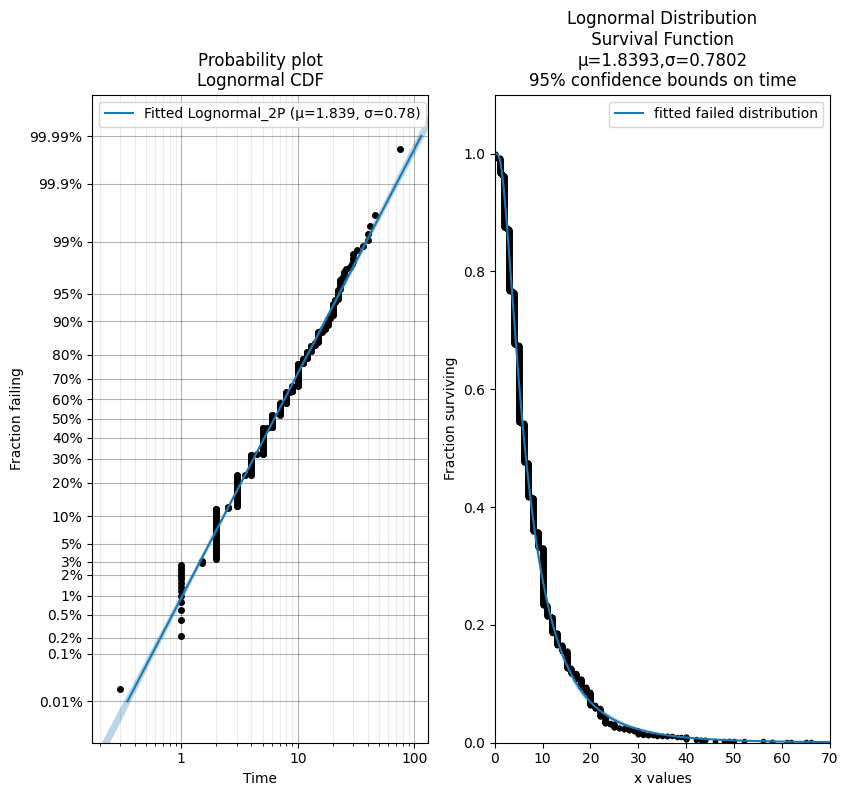

Results from Fit_Lognormal_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 1479/0 (0% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
       Mu         1.79315       0.0201791    1.7536    1.8327
    Sigma        0.776044       0.0142688  0.748575   0.80452 

Goodness of fit    Value
 Log-likelihood -4375.69
           AICc  8755.38
            BIC  8765.97
             AD   6.8065 



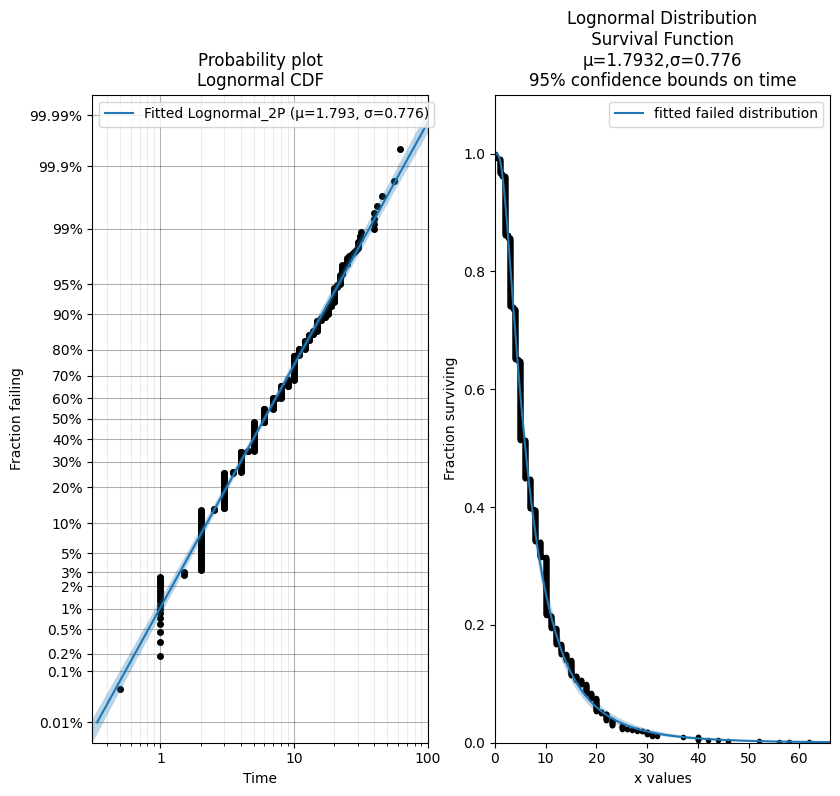

Results from Fit_Lognormal_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 2182/0 (0% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
       Mu         1.87065       0.0167291   1.83786   1.90344
    Sigma         0.78145       0.0118293  0.758605  0.804982 

Goodness of fit    Value
 Log-likelihood -6639.79
           AICc  13283.6
            BIC    13295
             AD  8.07463 



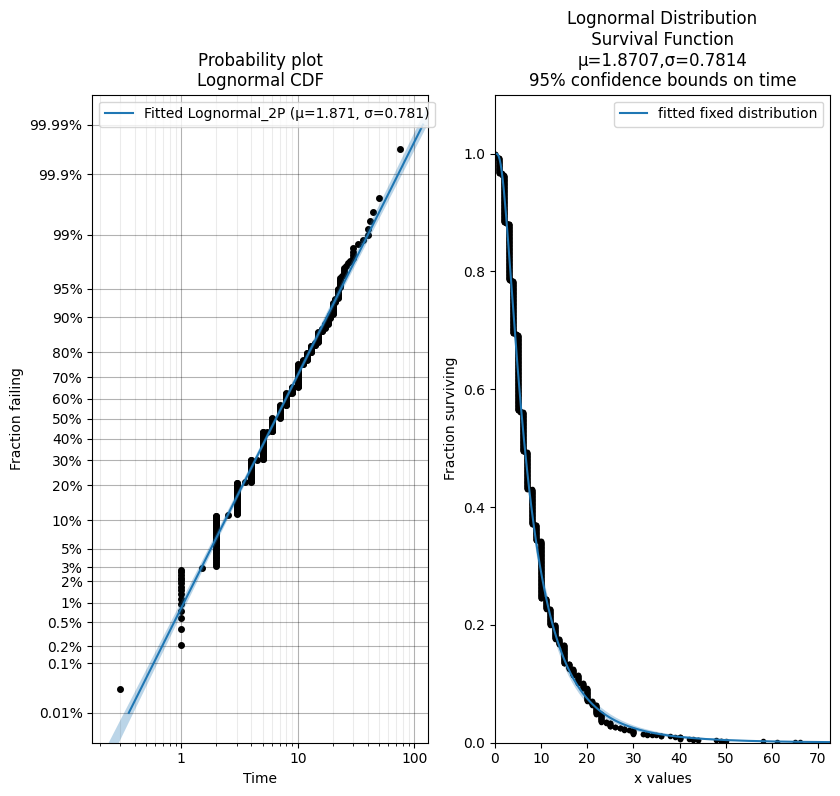

In [23]:
from reliability.Fitters import Fit_Weibull_2P, Fit_Weibull_3P, Fit_Everything, Fit_Lognormal_2P
from reliability.Probability_plotting import plot_points
import matplotlib.pyplot as plt
from reliability.Repairable_systems import reliability_growth

plt.subplot(121)
fit_all = Fit_Lognormal_2P(failures=df_vac.tolist())  # fits a Weibull distribution to the data and generates the probability plot
plt.subplot(122)
fit_all.distribution.SF(label='fitted failed distribution')  # uses the distribution object from Fit_Weibull_2P and plots the survival function
plot_points(failures=df_vac.tolist(), func='SF')  # overlays the original data on the survival function
plt.legend()
plt.show()

plt.subplot(121)
fit_failed = Fit_Lognormal_2P(failures=df_vac_failed.tolist())  # fits a Weibull distribution to the data and generates the probability plot
plt.subplot(122)
fit_failed.distribution.SF(label='fitted failed distribution')  # uses the distribution object from Fit_Weibull_2P and plots the survival function
plot_points(failures=df_vac_failed.tolist(), func='SF')  # overlays the original data on the survival function
plt.legend()
plt.show()

plt.subplot(121)
fit_fixed = Fit_Lognormal_2P(failures=df_vac_fixed.tolist())  # fits a Weibull distribution to the data and generates the probability plot
plt.subplot(122)
fit_fixed.distribution.SF(label='fitted fixed distribution')  # uses the distribution object from Fit_Weibull_2P and plots the survival function
plot_points(failures=df_vac_fixed.tolist(), func='SF')  # overlays the original data on the survival function
plt.legend()
plt.show()

In [47]:
fit_all.mu, fit_all.sigma

(1.8361497350709535, 0.7919796843078976)

In [28]:
fit_all.distribution.CDF([1.9,2,2.1], show_plot=False)

array([0.0624099 , 0.07090153, 0.07977688])

In [29]:
import math
from scipy.special import erf

def lognormal_cdf(x, mu, sigma):
    if x <= 0:
        return 0.0  # CDF is 0 for x <= 0

    # Calculate the CDF for the lognormal distribution
    cdf = 0.5 * (1 + erf((math.log(x) - mu) / (math.sqrt(2) * sigma)))
    return cdf

In [30]:
# Example usage:
mu = fit_all.mu  # Replace with your specific mu value
sigma = fit_all.sigma  # Replace with your specific sigma value
age_input = 2.0  # Replace with your specific age input in years

result = lognormal_cdf(age_input, mu, sigma)
print(f"The cumulative distribution function at age {age_input} years is: {result}")

The cumulative distribution function at age 2.0 years is: 0.07090153011664435


#### Step5. Build a dataset of lognormal models for every object category  

In [35]:
results=[]
for my_cat in tqdm(df.product_category.unique()):
    result={}
    result["prod_cat"]=my_cat
    df_cat=df[df.product_category==my_cat].product_age.replace(0,0.5).dropna()
    number=df_cat.shape[0]
    result["prod_cat_number"]=number
    fit_all = Fit_Lognormal_2P(failures=df_cat.tolist(),show_probability_plot=False, print_results=False)
    result["mu"]=fit_all.mu
    result["sigma"]=fit_all.sigma
    result["mu_SE"]=fit_all.mu_SE
    result["sigma_SE"]=fit_all.sigma_SE
    result["mu_upper"]=fit_all.mu_upper
    result["sigma_upper"]=fit_all.sigma_upper
    result["mu_lower"]=fit_all.mu_lower
    result["sigma_lower"]=fit_all.sigma_lower
    results.append(result)
df_results=pd.DataFrame(results)

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 29.08it/s]


In [36]:
df_results

,prod_cat,prod_cat_number,mu,sigma,...,mu_upper,sigma_upper,mu_lower,sigma_lower
0,PRINTER/SCANNER,995,1.74802,0.730348,...,1.7934,0.763152,1.70264,0.698954
1,HEADPHONES,509,1.22206,0.909054,...,1.30103,0.966648,1.14308,0.854892
2,LAPTOP,2264,1.79065,0.657928,...,1.81775,0.677374,1.76355,0.639041
3,SEWING MACHINE,1568,2.91217,0.927739,...,2.95809,0.960784,2.86625,0.89583
4,TOY,678,1.7307,1.3184,...,1.82994,1.39048,1.63146,1.25006
5,SMALL HOME ELECTRICAL,1229,1.8052,0.995687,...,1.86086,1.03584,1.74953,0.957093
6,TOASTER,1052,1.86583,0.932494,...,1.92218,0.973202,1.80949,0.893488
7,MOBILE,894,1.20333,0.783999,...,1.25473,0.821193,1.15194,0.748488
8,HAIR & BEAUTY ITEM,759,1.78066,0.957545,...,1.84878,1.00695,1.71254,0.910568
9,HI-FI SEPARATES,3020,2.62137,0.910615,...,2.65384,0.933872,2.58889,0.887937
